In [15]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV
from math import sqrt
import pickle

In [16]:
data = pd.read_csv('Data review - Sheet1.csv')

In [3]:
data

,Unnamed: 0,DEPTH (FT AH),SG (Oil Gravity) @ 60/60F,API,"Viscosity @ SC, cSt","Temp (deg F, res)","Viscosity @ RC, cp",Pressure,"Uob, cp","Uo, cp"
0,NaN,6989,0.95,17.8,121.00,126,13.0,2890,14.0,14.0
1,NaN,6989,0.95,17.8,112.60,126,13.0,2890,14.0,14.0
2,NaN,6989,0.95,18.3,127.30,126,14.0,2890,15.0,15.0
3,NaN,6994,0.95,18.0,114.60,126,13.0,2890,14.0,14.0
4,NaN,6994,0.95,17.9,113.90,126,13.0,2890,14.0,14.0
...,...,...,...,...,...,...,...,...,...,...
357,NaN,9820,0.91,23.3,17.32,171,5.1,4200,11.0,25.0
358,NaN,9820,0.92,22.5,20.04,171,5.9,4200,12.0,28.0
359,NaN,10544,0.82,40.2,2.82,191,0.9,4500,2.1,6.7
360,NaN,10135,0.83,38.9,2.86,191,0.9,4500,1.0,1.2


In [4]:
data.columns

Index(['Unnamed: 0', 'DEPTH (FT AH)', 'SG (Oil Gravity) @ 60/60F', 'API',
       'Viscosity @ SC, cSt', 'Temp (deg F, res)', 'Viscosity @ RC, cp',
       'Pressure', 'Uob, cp', 'Uo, cp'],
      dtype='object')

In [5]:
data = data.drop(['Unnamed: 0', 'Uo, cp'], axis = 1)

In [6]:
data

,DEPTH (FT AH),SG (Oil Gravity) @ 60/60F,API,"Viscosity @ SC, cSt","Temp (deg F, res)","Viscosity @ RC, cp",Pressure,"Uob, cp"
0,6989,0.95,17.8,121.00,126,13.0,2890,14.0
1,6989,0.95,17.8,112.60,126,13.0,2890,14.0
2,6989,0.95,18.3,127.30,126,14.0,2890,15.0
3,6994,0.95,18.0,114.60,126,13.0,2890,14.0
4,6994,0.95,17.9,113.90,126,13.0,2890,14.0
...,...,...,...,...,...,...,...,...
357,9820,0.91,23.3,17.32,171,5.1,4200,11.0
358,9820,0.92,22.5,20.04,171,5.9,4200,12.0
359,10544,0.82,40.2,2.82,191,0.9,4500,2.1
360,10135,0.83,38.9,2.86,191,0.9,4500,1.0


In [7]:
#now to find the original eror between Prof's method and machine learning method
mse_pre =  mean_squared_error(data["Uob, cp"].values, data["Viscosity @ RC, cp"].values)
mae_pre = mean_absolute_error(data["Uob, cp"].values, data["Viscosity @ RC, cp"].values)
r2_pre = r2_score(data["Uob, cp"].values, data["Viscosity @ RC, cp"].values)
rmse_pre = sqrt(mse_pre)

print(f"The Values of the error of Prof's with respect to the Truth values varies as follows \n 1. Mean Squared Error {mse_pre} \n 2.Root Mean Squared Error {rmse_pre} \n 3. Mean Absolute Error {mae_pre} \n 4. The R2 Score {r2_pre}")

The Values of the error of Prof's with respect to the Truth values varies as follows 
 1. Mean Squared Error 44.25302099447514 
 2.Root Mean Squared Error 6.652294415799345 
 3. Mean Absolute Error 4.085524861878453 
 4. The R2 Score 0.5585219623674234


In [8]:
#make a copy of the data, rewrite a Gradient boosting algorithm using Grid search and get the 
#results and use it to do machine learning 
dataset = data.copy()
dataset = dataset.drop("Viscosity @ RC, cp", axis = 1)
y = dataset["Uob, cp"].values
X = dataset.drop('Uob, cp', axis = 1)
X.shape

(362, 6)

In [9]:
estimator  = GradientBoostingRegressor(n_estimators = 120, random_state= 42)
params  = {'n_estimators': np.arange(40, 300, 10), "learning_rate": np.arange(0.01, 0.1, 0.01), "max_depth" : [2, 3, 4, 5, 6, 7, 8, 9], "min_samples_leaf": np.arange(1, 10), "max_features": [2, 3, 0.5, 'auto','sqrt', 'log2', None]}

In [34]:
gridsearch = GridSearchCV(estimator=estimator, cv=5, param_grid = params, n_jobs = -1, scoring= "neg_mean_squared_error")
gridsearch.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=120,
                                                 n_iter_n...
                         'ma

In [ ]:
gridsearch.best_params_

In [17]:
mean_squared_error(y, gridsearch.predict(X))

0.1266669995766966

In [21]:
#These are the prediction for Gradient bosting 
predictions_grid  = gridsearch.predict(X)
predictions_grid

array([14.31570935, 13.67934455, 14.989855  , 13.82979202, 13.82979202,
       16.32850455, 11.5275945 , 14.98280909, 14.25134782, 13.71734709,
       16.39094909, 20.14323595, 17.92373567, 20.97256562, 19.70512189,
       27.59802207, 21.44813974, 33.29511178, 21.43306988, 27.37090144,
       28.96725156, 28.44720414, 27.32053805, 26.0620343 , 28.64641993,
       30.41181845, 30.90815054, 26.74487995, 27.13227382, 22.44103327,
       22.49849717, 22.19179741, 23.55573122, 25.72538079, 25.69723157,
       29.61047179, 17.31205374, 18.30653222, 18.4276121 ,  2.84258674,
        3.08279661,  1.96943993,  2.57444684,  2.49462096,  2.88282083,
        2.88282083,  2.71038647,  2.97641206,  3.43003243,  3.61722771,
        3.66741164,  3.50617908,  3.48805455,  1.39219064,  1.32037921,
        1.31415689,  1.33314418,  1.33314418,  1.33660407,  1.33314418,
        1.34625998,  1.33314418,  1.33314418,  1.33314418,  1.33314418,
        1.33314418,  1.1878935 ,  1.40113885,  1.32037921,  1.38

In [40]:
gridsearch.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.060000000000000005,
                          loss='ls', max_depth=3, max_features=3,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=3,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=290, n_iter_no_change=None,
                          presort='deprecated', random_state=42, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [41]:
gridsearch

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=120,
                                                 n_iter_n...
                         'ma

In [42]:
#saving the model in a pickle file
file_name = "grad_boost.pkl"
with open(file_name, 'wb') as file:
    pickle.dump(gridsearch.best_estimator_, file)

In [11]:
#loading and predicting the model
gridsearch =  pickle.load(open("grad_boost.pkl", "rb"))
mse_grid = mean_squared_error(y, gridsearch.predict(X))
rmse_grid = sqrt(mse_grid)
mae_grid = mean_absolute_error(y, gridsearch.predict(X))
r2_grid = r2_score(y, gridsearch.predict(X))
print(f"The Values of the error of Gradient Boosting with respect to the Truth values varies as follows \n 1. Mean Squared Error {mse_grid} \n 2.Root Mean Squared Error {rmse_grid} \n 3. Mean Absolute Error {mae_grid} \n 4. The R2 Score {r2_grid}")

The Values of the error of Gradient Boosting with respect to the Truth values varies as follows 
 1. Mean Squared Error 0.1266669995766966 
 2.Root Mean Squared Error 0.3559030760989523 
 3. Mean Absolute Error 0.23132209008488908 
 4. The R2 Score 0.9987363416745513


In [14]:
#now to prepare a RandomForest regressor
params_rf  = {'n_estimators': np.arange(40, 300, 10), "max_depth" : [2, 3, 4, 5, 6, 7, 8, 9], "min_samples_leaf": np.arange(1, 10), "max_features": [2, 3, 0.5, 'auto','sqrt', 'log2', None]}
estimator_rf = RandomForestRegressor(random_state = 42)
gridsearch_rf = GridSearchCV(estimator=estimator_rf, cv=5, param_grid = params_rf, n_jobs = -1, scoring= "neg_mean_squared_error")
gridsearch_rf.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [2, 3, 0.5, 'aut

In [15]:
#now to get the best params
gridsearch_rf.best_params_

{'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 40}

In [ ]:
#saving model and loading into the disk space
file_name = "random_forest.pkl"
with open(file_name, 'wb') as file:
    pickle.dump(gridsearch_rf.best_estimator_, file)

In [24]:
#loading and predicting the model
gridsearch_rf =  pickle.load(open("random_foreest.pkl", "rb"))
mse_forest = mean_squared_error(y, gridsearch_rf.predict(X))
rmse_forest = sqrt(mse_forest)
mae_forest = mean_absolute_error(y, gridsearch_rf.predict(X))
r2_forest = r2_score(y, gridsearch_rf.predict(X))
print(f"The Values of the error of Random Forest with respect to the Truth values varies as follows \n 1. Mean Squared Error {mse_forest} \n 2. Root Mean Squared Error {rmse_forest} \n 3. Mean Absolute Error {mae_forest} \n 4. The R2 Score {r2_forest}")

The Values of the error of Random Forest with respect to the Truth values varies as follows 
 1. Mean Squared Error 0.46617794315047945 
 2. Root Mean Squared Error 0.6827722483745802 
 3. Mean Absolute Error 0.328511503365855 
 4. The R2 Score 0.9953493045467934


In [28]:
predictions_random = gridsearch_rf.predict(X)

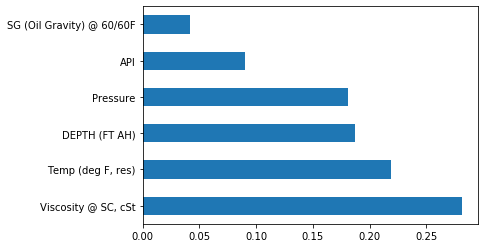

In [14]:
#let us try to visualize the most important features
feat_importances = pd.Series(gridsearch_rf.feature_importances_, index=X.columns)
feat_importances.nlargest(6).plot(kind='barh')

In [19]:
# Extract the small tree
import pydot
tree_small = gridsearch_rf.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = X.columns, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [21]:
#now to prepare AdaBoost
estimator_ada = AdaBoostRegressor(random_state = 42)
params_ada = {'n_estimators': np.arange(40, 300, 10), "learning_rate": np.arange(0.01, 0.1, 0.01), "loss": ["linear", "square", "exponential"]}
gridsearch_ada = GridSearchCV(estimator=estimator_ada, cv=5, param_grid = params_ada, n_jobs = -1, scoring= "neg_mean_squared_error")
gridsearch_ada.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=42),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': array([ 40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160,
       170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [22]:
gridsearch_ada.best_params_

{'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 40}

In [ ]:
#saving model and loading into the disk space
file_name = "ada_boost.pkl"
with open(file_name, 'wb') as file:
    pickle.dump(gridsearch_ada.best_estimator_, file)

In [25]:
#loading and predicting the model
gridsearch_ada =  pickle.load(open("ada_boost.pkl", "rb"))
mse_ada = mean_squared_error(y, gridsearch_ada.predict(X))
rmse_ada = sqrt(mse_ada)
mae_ada = mean_absolute_error(y, gridsearch_ada.predict(X))
r2_ada = r2_score(y, gridsearch_ada.predict(X))
print(f"The Values of the error of Adaptive Boosting(AdaBoost) with respect to the Truth values varies as follows \n 1. Mean Squared Error {mse_ada} \n 2. Root Mean Squared Error {rmse_ada} \n 3. Mean Absolute Error {mae_ada} \n 4. The R2 Score {r2_ada}")

The Values of the error of Adaptive Boosting(AdaBoost) with respect to the Truth values varies as follows 
 1. Mean Squared Error 5.0497814801721335 
 2. Root Mean Squared Error 2.247171884874883 
 3. Mean Absolute Error 1.4238424352112078 
 4. The R2 Score 0.9496222502274353


In [26]:
predictions_ada = gridsearch_ada.predict(X)

In [27]:
data["Gradient Boost Predictions"] = predictions_grid

In [29]:
data["Random Forest Predictions"] = predictions_random
data["Adaptive Boost Predictions"] = predictions_ada

In [30]:
data.head()

,Unnamed: 0,DEPTH (FT AH),SG (Oil Gravity) @ 60/60F,API,"Viscosity @ SC, cSt","Temp (deg F, res)","Viscosity @ RC, cp",Pressure,"Uob, cp","Uo, cp",Gradient Boost Predictions,Random Forest Predictions,Adaptive Boost Predictions
0,NaN,6989,0.95,17.8,121.0,126,13.0,2890,14.0,14.0,14.315709,14.585972,15.529412
1,NaN,6989,0.95,17.8,112.6,126,13.0,2890,14.0,14.0,13.679345,14.255913,15.352941
2,NaN,6989,0.95,18.3,127.3,126,14.0,2890,15.0,15.0,14.989855,14.602083,15.533333
3,NaN,6994,0.95,18.0,114.6,126,13.0,2890,14.0,14.0,13.829792,14.249454,15.529412
4,NaN,6994,0.95,17.9,113.9,126,13.0,2890,14.0,14.0,13.829792,14.249454,15.529412


In [32]:
!pip install openpyxl
data.to_excel("Final Predicted values.xlsx")

     |████████████████████████████████| 172 kB 16 kB/s eta 0:00:01
  Created wheel for openpyxl: filename=openpyxl-3.0.3-py2.py3-none-any.whl size=241262 sha256=b3b131be691228f4c580889756d7be7407b3dc781c33db6e6e29d2bc022a7e9f
  Stored in directory: /home/michael/.cache/pip/wheels/5b/c0/e7/e16d3916984addf40bd021fa98d1624cb24a9adc48da4e62b5
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8915 sha256=06dc942e2c1dbc1d17b852e74b9ecb77133f55c9d029007c86ae8cefe09ab3a5
  Stored in directory: /home/michael/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built openpyxl et-xmlfile
